# Text classification
 - In this notebook we will create a deep learning classifier for text classification starting from raw text. We'll use the IMDB sentiment classification dataset (unprocessed version).
 - 1\) Load data 
 - 2\) Preprocessing
 - 3\) Data exploration
 - 4\) Prepare input samples for input to neural networks
 - 5\) Download and prepare pretrained word embeddings
 - 6\) Train classifier
 - 7\) Test on test set and analyze the results

## Load data

In [1]:
# Load the IMDB data from your local directory

# Mount drive if using Colab
# from google.colab import drive
# drive.mount('/content/drive')

def load_data(path):
    samples=[]
    labels=[]
    with open(path, encoding='utf8') as f:
        for line in f:
            labels.append(int(line[0])) #First char is the label (0=Negative, 1 = positive)
            samples.append(line[2:-2]) #Append the text except for '\n'-linebreaks
    return labels, samples
#Load x_train and y_train 
y_train, x_train = load_data('imdb_dataset_train.txt')
#Load x_test and y_test
y_test, x_test = load_data('imdb_dataset_test.txt')
print('Number of training samples: {}\nNumber of test samples: {}'.format(len(y_train), len(y_test)))
#print(x_train[1])

Number of training samples: 25000
Number of test samples: 25000


## Preprocessing
 - Read through some samples - what do you see? Can we remove something to help our classifier?
 - Remember that you should only preprocess your data based on your findings of the training dataset. Why?

In [2]:
# Print some samples and read through. 
# How many samples should we read before making conclusions?
for sample in x_train[0:3]:
    print(sample,"\n")

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't 

Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going t

In [3]:
# Let's preprocess the text by removing special chars and string patterns
# For this we will use Regular expressions (Regex) 
# There are many options when using Regex, and sometimes they can look quite confusing. They are, however, really efficient for preprocessing.  
# In short: Define a list of chars that need to be removed within a '[]' called a character set. 
#           Different groups within a regex can be seperated by '|' a logical OR. 
#           What do we do if we want to remove the actual char '|' in a string? Insert a leading backslash '\|'. 
# For more information: https://docs.python.org/3/library/re.html
# For building a Rexex: https://regexr.com/

#Example
import re
x = '(I) will, preprocess <HTML /> +this!! noisy . sentence!"# with a regular expression ..<HTML>...'
#We'll use 're.sub(pattern, repl, string)' for preprocessing. 
#                 Pattern: The pattern (defined by a regex) to be replaced
#                 repl: The replacement value
#                 string: string to process
new_x = re.sub('[\()!.,\|\+"#]|<HTML />|<HTML>', '', x) #Remove single chars and string patterns
new_x = re.sub('\s+', ' ', new_x.strip()) #Removes superfluous spaces, '\s' defines a space, '+' matches one or more of the preceding token, i.e. it matches multiple spaces
print("Original sentence: {}\nNew sentence:      {}".format(x, new_x))

Original sentence: (I) will, preprocess <HTML /> +this!! noisy . sentence!"# with a regular expression ..<HTML>...
New sentence:      I will preprocess this noisy sentence with a regular expression


In [4]:
# Your turn!
# Create a Regex to preprocess x_train and save result in x_train_pre
# Which chars and string pattern should be removed? (Have you noticed any html-tags in the samples?)

x_train_pre = []

removeBr = ""

for sample in x_train:
    removeBr = re.sub('[\()!.,\|\+"#]|<br />|<br>', '', sample) #Remove single chars and string patterns
    removeBr = re.sub('\s+', ' ', removeBr.strip())

    x_train_pre.append(removeBr)

for sample in x_train_pre[0:3]:
    print(sample,"\n")

Bromwell High is a cartoon comedy It ran at the same time as some other programs about school life such as Teachers My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is Teachers The scramble to survive financially the insightful students who can see right through their pathetic teachers' pomp the pettiness of the whole situation all remind me of the schools I knew and their students When I saw the episode in which a student repeatedly tried to burn down the school I immediately recalled at High A classic line: INSPECTOR: I'm here to sack one of your teachers STUDENT: Welcome to Bromwell High I expect that many adults of my age think that Bromwell High is far fetched What a pity that it isn't 

Homelessness or Houselessness as George Carlin stated has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school work or vote for the matter Mos

In [5]:
# Lower case
# Should we lower case our data? Why? 

#Example:
x = ['I wiLL LoWeR case THIS STRING using str.lower()', 'THis OnE aS WelL']
x = [sample.lower() for sample in x] 
print(x)

['i will lower case this string using str.lower()', 'this one as well']


In [6]:
# Your turn! 
# Lower case x_train_pre if you believe it should so.
x_train_pre = [sample.lower() for sample in x_train_pre]

for sample in x_train_pre[0:3]:
    print(sample,"\n")

bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell high's satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers' pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled at high a classic line: inspector: i'm here to sack one of your teachers student: welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isn't 

homelessness or houselessness as george carlin stated has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school work or vote for the matter mos

## Quantitative data exploration

Average length positive 232.6
Average length negative: 226.5


[]

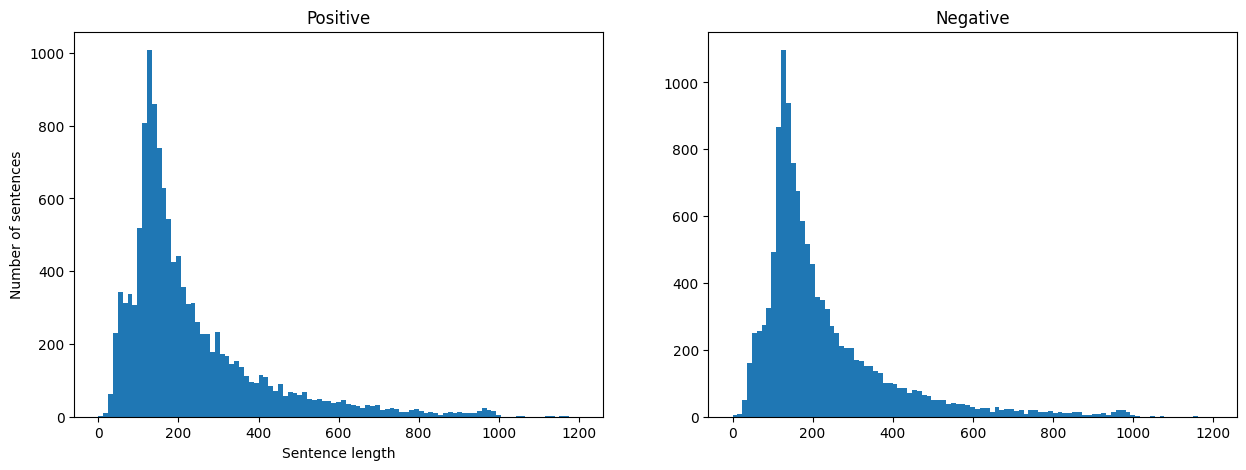

In [7]:
# Let's make some sample staistics
# Here we will calculate and plot the sentence length of x_train

import math
import matplotlib.pylab as plt
import numpy as np

# Function for calculation of length and average length of samples
def avg_length(samples):
    length = [len(sample.split()) for sample in samples]
    return len(length), round(sum(length)/len(length),1), length

# Create list of positive and negative samples
positive = [s for i, s in enumerate(x_train_pre) if y_train[i]==1]
negative= [s for i, s in enumerate(x_train_pre) if y_train[i]==0]

# Calculate length and average length of each class
_, avg_positive, length_positive = avg_length(positive)
_, avg_negative, length_negative = avg_length(negative)
print("Average length positive {}\nAverage length negative: {}".format(avg_positive, avg_negative))

#Plot results
fig, ax = plt.subplots(1,2, figsize=(15,5)) 
bins = np.linspace(0, 1200, 100)
bins1 = np.linspace(0, 1200, 100)

ax[0].title.set_text('Positive')
ax[1].title.set_text('Negative')

ax[0].set_ylabel('Number of sentences')
ax[0].set_xlabel('Sentence length')

ax[0].hist(length_positive, bins=bins)
ax[1].hist(length_negative, bins=bins1)
plt.plot()

In [8]:
# Do you notice something eye cathing in the above graphs and results?
# Can we use the sentence length to make a classification of positive vs. negative?

In [9]:
# Let's calculate the most common words

from collections import Counter
#Merge all samples to a single string
all_words = ' '.join(x_train_pre)
#Split using spaces
all_words = all_words.split()
# Pass all_words list to instance of Counter class.
Counter = Counter(all_words)
# Most_common() produces k frequently encountered input values and their respective counts.
most_occur = Counter.most_common(20)
print(most_occur)
print("Word count of 'fantastic': ", Counter['fantastic'])

[('the', 327316), ('and', 161509), ('a', 161165), ('of', 145096), ('to', 134769), ('is', 106566), ('in', 92090), ('it', 75613), ('this', 72767), ('i', 72324), ('that', 68912), ('was', 47927), ('as', 45997), ('with', 43684), ('for', 43628), ('movie', 41195), ('but', 40963), ('film', 36978), ('on', 33232), ('not', 29908)]
Word count of 'fantastic':  764


In [10]:
# Your turn! 
# Calculate most occuring words for each class 
## Remember that we added positive samples to the list 'positive' and negatives in the list 'negative' earlier which can be used here
# Do we see different distributions in negatively and positively charged words in the different classes?  
# E.g., for each class, how many samples include the word 'fantastic'? What about 'terrible'? Experiment with a few words
# Can we use this for classification?
# If the most occuring words are similar in each class, we could use this as a way to define stop words (You don't have to do this now, it's just a consideration).

from collections import Counter

#Merge all samples to a single string
all_words = ' '.join(positive)
#Split using spaces
all_words = all_words.split()
# Pass all_words list to instance of Counter class.
counter = Counter(all_words)
# Most_common() produces k frequently encountered input values and their respective counts.
most_occur = counter.most_common(20)
print(most_occur)

#Merge all samples to a single string
all_words = ' '.join(negative)
#Split using spaces
all_words = all_words.split()
# Pass all_words list to instance of Counter class.
counter = Counter(all_words)
# Most_common() produces k frequently encountered input values and their respective counts.
most_occur = counter.most_common(20)
print(most_occur)

[('the', 168534), ('and', 88494), ('a', 82680), ('of', 76465), ('to', 66298), ('is', 56898), ('in', 49246), ('it', 37740), ('i', 34003), ('that', 33875), ('this', 33590), ('as', 25819), ('with', 23039), ('for', 22118), ('was', 21800), ('but', 20011), ('film', 19393), ('movie', 17955), ('his', 17119), ('on', 16533)]
[('the', 158782), ('a', 78485), ('and', 73015), ('of', 68631), ('to', 68471), ('is', 49668), ('in', 42844), ('this', 39177), ('i', 38321), ('it', 37873), ('that', 35037), ('was', 26127), ('movie', 23240), ('for', 21510), ('but', 20952), ('with', 20645), ('as', 20178), ('film', 17585), ('on', 16699), ('not', 15916)]


## Prepare data for input to neural network
 - 1\) Create word dictionary using Keras' tokenizer layer
 - 2\) Transform each sample to list of integers using the word dictionary
 - 3\) Pad all samples
 - 4\) Split into train and validation data

In [11]:
# Create word dictionary

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

max_words = 50000
# Use Keras tokenizer to split words into tokens using spaces and to build the word index
tokenizer = Tokenizer(num_words=max_words, filters='', lower=True, split=' ', oov_token=None)
                    # 'Num_words': Only consider max_words-1 most frequent words - the other words will get index=OOV_token. If oov_token=None: words not in top x are ignored.
                    # 'Filter': Keras also provides a simple way to filter (remove) special tokens but we've already taken care of the preprocessing. Well done :-)
                    # 'lower': If True, lowercases the text corpus
                    # 'split': We tokenize our corpus using spaces

# Fit on x_train_pre
tokenizer.fit_on_texts(x_train_pre) #Builds the word index
# Get word_index for inspection
word_index = tokenizer.word_index
print('Found {} unique tokens.'.format(len(word_index)))
print("Top x words in word_index dictionary:\n", list(word_index.items())[:5])

2022-12-15 21:48:41.597344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 169264 unique tokens.
Top x words in word_index dictionary:
 [('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5)]


In [12]:
# Transform each sample to list of integers using the word dictionary. 

# Turn strings into lists of integers using Keras text_to_seq layer which uses the word index we created above
sequences = tokenizer.texts_to_sequences(x_train_pre) 
#Padding and truncation: Define maximum length of input sample that we want to feed to the neural network (if sample is longer we'll truncate it)
maxlen = 150 # What should this be? What are the pros and cons?
sequences = pad_sequences(sequences, maxlen=maxlen, padding='pre', truncating='pre') #Is it resonable to use 'pre' padding and truncation?
y_train = np.asarray(y_train)
print('Shape of samples:', sequences.shape)
print('Shape of labels:', y_train.shape)
print("\nOriginal sentence: {}\nSequence sentence: {}".format(x_train_pre[0], sequences[0]))

Shape of samples: (25000, 150)
Shape of labels: (25000,)

Original sentence: bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell high's satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers' pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled at high a classic line: inspector: i'm here to sack one of your teachers student: welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isn't
Sequence sentence: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0 22496   323     6     3  1071   222   

In [13]:
# Shuffle the dataset
np.random.seed(1234)
indices = np.random.permutation(sequences.shape[0])
sequences_ = sequences[indices]
y_train_ = y_train[indices]

#Shuffle the preprocessed text data as well
x_train_pre = np.asarray(x_train_pre)
x_train_pre = x_train_pre[indices]

In [14]:
# Split samples into train and validation set
# How many samples do you want to train with and how many for evaluation - why?
training_samples = 20000
validation_samples = len(sequences_)-training_samples
x_train_seq = sequences_[:training_samples]
y_train_seq = y_train_[:training_samples]
x_val_seq = sequences_[training_samples: training_samples + validation_samples]
y_val_seq = y_train_[training_samples: training_samples + validation_samples]
print('Training samples:', len(x_train_seq))
print('Validation samples:', len(x_val_seq))
#print(x_val_seq[0])

Training samples: 20000
Validation samples: 5000


## Prepare pretrained word embeddings for Keras embedding layer
 - Which word embeddings do you want to work with? FastText, GloVe, other? Why?

In [20]:
# FastText word embeddings

#Downloads English Fasttext word embeddings
#!pip install fasttext
import fasttext.util
from tqdm.notebook import tqdm
fasttext.util.download_model('en', if_exists='ignore') 
#Load model
ft_model = fasttext.load_model('cc.en.300.bin') 

embedding_dim=ft_model.get_dimension() #Get word embedding dimension
print("Embedding:", embedding_dim)

#Create our embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
print(embedding_matrix.shape)
for word, i in tqdm(word_index.items()):
    if i < max_words:
        embedding_matrix[i] = ft_model[word] #Add words to matrix
print("Are word embedding marix and word_index aligned?: {}".format(np.array_equal(ft_model['movie'], embedding_matrix[word_index['movie']])))

Embedding 300
(50000, 300)


  0%|          | 0/169264 [00:00<?, ?it/s]

Are word embedding marix and word_index aligned?: True


In [16]:
# GloVe word embeddings

# Download english embeddings from https://nlp.stanford.edu/projects/glove/ 
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

# Add directory of your word embeddings
glove_dir = '/Users/berkankutuk/Desktop/Deep-learning-nlp/glove.6B/glove.6B.100d.txt'
embeddings_index = {} #Dictionary for our word embeddings

#Load embeddings into dictionary
f = open(glove_dir, encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found {} word vectors.'.format(len(embeddings_index)))

#Preparing the GloVe word-embeddings matrix
embedding_dim=100
#Create our embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
oov_words=[]

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word) 
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector #Add words to matrix
        else:
            oov_words.append(word) #words not in vocab! They will get zero-vectors
print("\nnumber of OOV words: ", len(oov_words), "\nExamples:")
oov_words.sort()
print(oov_words[20:30])

Found 400000 word vectors.

number of OOV words:  11302 
Examples:
['$250', '$2500', '$25000', '$250000', '$299', '$3', '$30', '$300', '$3000', '$3000000']


In [17]:
# Load embeddings using Gensim

#Gensim has the following pretrained models ready to load:  
# 'conceptnet-numberbatch-17-06-300': ConceptNet Numberbatch consists of state-of-the-art semantic vectors
# 'fasttext-wiki-news-subwords-300': 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).
# 'glove-twitter-100': Pre-trained vectors based on  2B tweets, 27B tokens, 1.2M vocab, uncased.
# 'glove-twitter-200': Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased.
# 'glove-twitter-25': Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased.
# 'glove-twitter-50': Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased.
# 'glove-wiki-gigaword-100': Pre-trained vectors based on Wikipedia 2014 + Gigaword 5.6B tokens, 400K vocab, uncased.
# 'glove-wiki-gigaword-200': Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased.
# 'glove-wiki-gigaword-300': Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased.
# 'glove-wiki-gigaword-50': Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased.
# 'word2vec-google-news-300': Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases.
# 'word2vec-ruscorpora-300': Word2vec Continuous Skipgram vectors trained on full Russian National Corpus (about 250M words).

import gensim
from gensim.models.word2vec import Word2Vec
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.models.fasttext import load_facebook_model
import gensim.downloader as api
model = api.load("fasttext-wiki-news-subwords-300")
#Define embedding dimensions
embedding_dim=300
#Create our embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
oov_words=[]

for word, i in word_index.items():
    if i < max_words: 
        if model.has_index_for(word):
            embedding_matrix[i] = model.get_vector(word) #Add words to matrix
        else:
            oov_words.append(word) #words not in vocab! They will get zero-vectors
print("\nnumber of OOV words: ", len(oov_words), "\nExamples:")
oov_words.sort()
print(oov_words[20:30])


number of OOV words:  14096 
Examples:
['$250', '$2500', '$25000', '$250000', '$299', '$3', '$30', '$300', '$3000', '$3000000']


## Train a classifier
 - How does the model performance change for:
 - GRU or LSTM vs. CNN
 - CNN: How many filters and which size should we use? You can also try using differet filter sizes in the same model (use the functional Keras API). 
 - RNN: What should the hidden size be? Does it help to stack layers? Do you find any difference between LSTM and GRU
 - Random initialized word embeddings vs. pretrained? 
 - There are many architectures and hyperparameters to explore - of course you can't explore all of them. 

In [26]:
# Train model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Input, SimpleRNN, MaxPooling1D, Concatenate, Dense, Flatten, LSTM, GRU, Bidirectional, Dropout, GlobalMaxPooling1D, MaxPooling1D, Conv1D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Model, load_model

# Create a classifier using a CNN or RNN/LSTM/GRU
#RNN model
def build_model():
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim,
                        input_length=None, 
                        weights=[embedding_matrix], #Delete 'weights=[embedding_matrix]' in order to train with random initialized word embeddings
                        trainable=False))
    model.add(Conv1D(32,7, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(32,7, activation='relu'))
    model.add(GlobalMaxPooling1D())

    model.add(Dense(2, activation='softmax')) #Classification layer - you could also use a sigmoid activation if you prefer
    return model

#Build model
model = build_model()

# Set some training hyperparameters (Change them to whatever you prefer)
epochs = 5
batch_size= 32
learning_rate = 0.0005
opt = Adam(learning_rate=learning_rate)

#Compile 
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["acc"])
history = model.fit(x_train_seq, 
                    y_train_seq,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val_seq, y_val_seq),
                    shuffle=True)

#Save model
model.save('IMDB_text_classifier.h5')  # creates a HDF5 file 'my_model.h5'

Epoch 1/5
625/625 [==============================] - 12s 17ms/step - loss: 0.5729 - acc: 0.6935 - val_loss: 0.4652 - val_acc: 0.7854
Epoch 2/5
625/625 [==============================] - 11s 18ms/step - loss: 0.4278 - acc: 0.8042 - val_loss: 0.4161 - val_acc: 0.8098
Epoch 3/5
625/625 [==============================] - 11s 18ms/step - loss: 0.3719 - acc: 0.8336 - val_loss: 0.4010 - val_acc: 0.8122
Epoch 4/5
625/625 [==============================] - 11s 17ms/step - loss: 0.3337 - acc: 0.8569 - val_loss: 0.3937 - val_acc: 0.8204
Epoch 5/5
625/625 [==============================] - 10s 17ms/step - loss: 0.2971 - acc: 0.8751 - val_loss: 0.4050 - val_acc: 0.8164


### Plot training

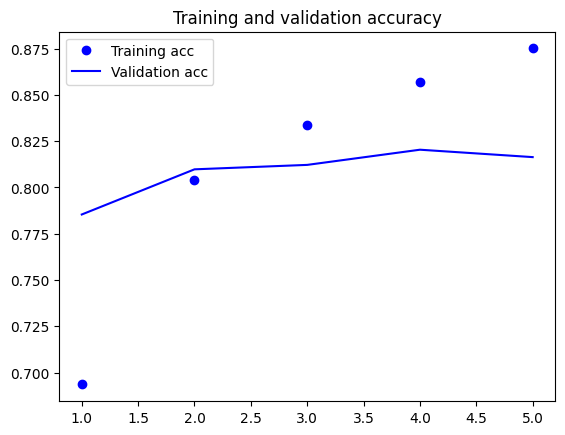

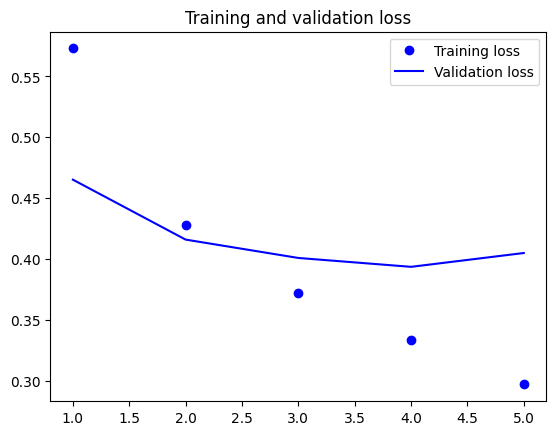

In [27]:
#Plotting results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Test you classifier on the test set
 - We have not prepared x_test and y_test for test. That's now up to you :-) 
 - When you have your result: Study the mistakes of the classifier - do you see a pattern? Could we have done something differently? 
 - Maybe we could have done better using data augmentation?
 - Remember: Even though you find ways to improve your result, once you have tested your classifier on the test set and reported the result, you can't go back and change your classifier and report a better one. If you wan't to make changes to the classifier based on an analysis of the classifier, you should make the analysis using the validation dataset. You have the possibility to do this in your final report. 

In [33]:
# Preprocess x_test using the regex you created for x_train
x_test_pre = []

for x in x_test:
    new_x = re.sub('[\()!.,\|\+"#]|<br />|<br>', '', x)
    new_x = re.sub('\s+', ' ', new_x.strip())
    new_x = re.sub('\.+', ' ', new_x.strip())

    x_test_pre.append(new_x)

for x in x_train_pre[0:3]:
    print(x, '\n')

#Turn strings into lists of integer indices using the word index
x_test_seq = tokenizer.texts_to_sequences(x_test_pre)
# Pad the text sequences
x_test_seq = pad_sequences(x_test_seq, maxlen=maxlen, padding='pre', truncating='pre')
#Convert y_test to numpy array
y_test = np.asarray(y_train)
print('Shape of data tensor:', x_test_seq.shape)
print('Shape of label tensor:', y_test.shape)
print("Original sentence: {}\nSequence sentence: {}".format(x_test_pre[0], x_test_seq[0]))

wrestlemania 14 is not often looked as one of the great wrestlemania's but i would personally put it in my top 5 if not the top 3 it has so many great things and it truly signified the birth of the attitude era which was wwe's best era in my opinion hbk has the heart of a lion and him putting over austin like he did on his way out was pure class on his part it has one of the hottest crowds you will ever see and it has jr and the king at their announcing best matches15  team battle royal loud pop for lod's return i'm not a fan of battle royal's and this is yet another average one very predictable even when you 1st see it it's obvious lod would win looking at sunny for 8 or so minutes though definitely helps 2/5wwf light heavyweight championshiptaka michinokuc vs aguilataka gets a surprising pop with his entrance fast high-flying and very exciting if these two had more time they would have surely tore the roof off with their stuff taka wins with the michinoku driver3 1/2 /5wwf european 

In [38]:
# Use model.evaluate to get your test result
model = load_model('IMDB_text_classifier.h5')
evaluate = model.evaluate(x_test_seq, y_test) # '(x,y)' does not work - What should we use as argument to model.evaluate? https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
print("Accuracy", round(evaluate[1],3), "loss: ", round(evaluate[0],3))

782/782 [==============================] - 7s 5ms/step - loss: 0.3979 - acc: 0.8204
Accuracy 0.82 loss:  0.398


In [41]:
# Print confussion matrix using sklearn

# We can get the softmax probabilities for each sample using model.predict()
predictions=model.predict(x_test_seq) #'(x)' does not work - What should we use as argument to model.predict? https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict

import sklearn
from sklearn.metrics import confusion_matrix
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.argmax(predictions, axis=1))
print(confusion_matrix)
prec_rec_f1 = sklearn.metrics.precision_recall_fscore_support(y_test, np.argmax(predictions, axis=1), average='binary')
print("Precision:",round(prec_rec_f1[0],3), "Recall:",round(prec_rec_f1[1],3), "F1:",round(prec_rec_f1[2],3))

782/782 [==============================] - 4s 5ms/step
[[ 9316  3184]
 [ 1305 11195]]
Precision: 0.779 Recall: 0.896 F1: 0.833


## Analyze the results of the classifier

In [42]:
# Print the false predictions and analyze: When does it make mistakes? Could we do more to help our classifier?
##  How confident is the classifier for false predictions?
def false_pos_neg(samples, labels, prediction):
    fp=[] #False positives
    fp_pred=[] # False positives predictions
    fn=[]
    fn_pred=[]
    for i in range(len(samples)):
        pred=np.argmax(prediction[i])
        if pred!=labels[i]:
            if pred==0:
                fn.append(str(predictions[i])+samples[i])
                fn_pred.append(list(predictions[i]))
            else:
                fp.append(str(predictions[i])+samples[i])
                fp_pred.append(list(predictions[i]))
    return fp, fp_pred, fn, fn_pred
fp, fp_pred, fn, fn_pred = false_pos_neg(x_test_pre, y_test, predictions)
print(fn[0], "\n\nAverage softmax scores for false positives: {}\nAverage softmax scores for false negatives: {}".format(np.average(fp_pred, axis=0), np.average(fn_pred, axis=0)))

[0.7255052 0.2744948]Night of the Hunted stars French porn star Brigitte LahaieIn factmany of the cast members in this slow-moving production were porn actors at the time of its frantic filmingThis film is certainly different than Rollin's usual lesbian vampire flicksbut it's not as memorable as for example Lips of Blood or FascinationLahaie plays an amnesiac hitchhiker who can't remember who she is or where she came fromMost of the film takes place in a modern apartment complexwhere Lahaie is being held by some kind of medical group that's treating a number of people with a similar conditionAnywayshe escapes from the monolithic office tower where the affected people are heldOn a highway outside of townshe meets a young manwho stops and picks her upNight of the Hunted offers plenty of nudityunfortunately the pace is extremely slowThe atmosphere is horribly sad and the relationship between Brigitte Lahaie and another asylum inmate Dominique Journet is well-developedStill Night of the Hu

Average length false positive 247.1
Average length false negative: 253.3


[]

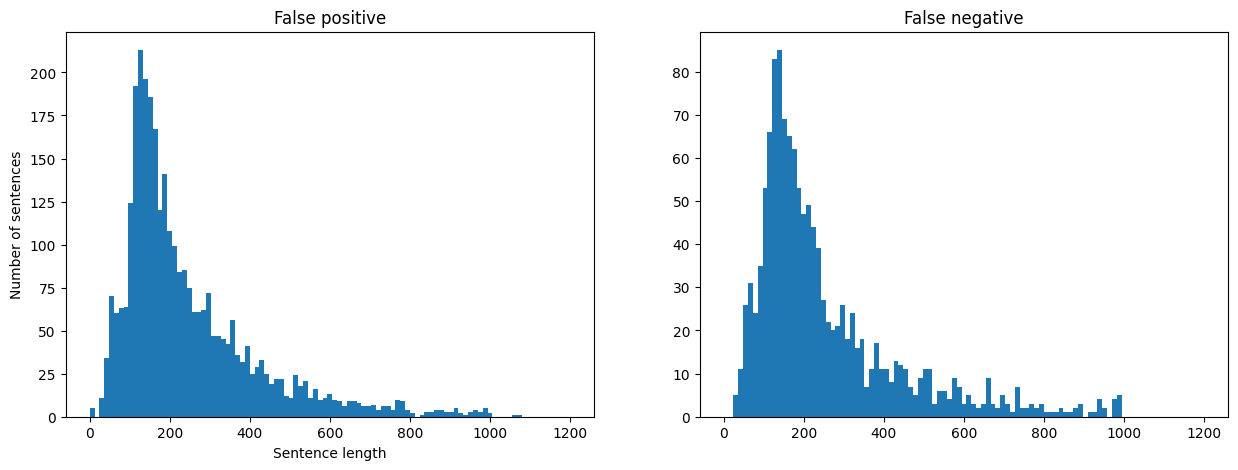

In [43]:
# If we have truncated the sentence at e.g. 150 words, it might be all the long sentences that we can't predict correctly?
# Calculate length and average length of each false prediction list (false_pos, false_neg)
_, avg_positive, length_positive = avg_length(fp)
_, avg_negative, length_negative = avg_length(fn)
print("Average length false positive {}\nAverage length false negative: {}".format(avg_positive, avg_negative))

#Plot results
fig, ax = plt.subplots(1,2, figsize=(15,5)) 
bins = np.linspace(0, 1200, 100)
bins1 = np.linspace(0, 1200, 100)

ax[0].title.set_text('False positive')
ax[1].title.set_text('False negative')

ax[0].set_ylabel('Number of sentences')
ax[0].set_xlabel('Sentence length')

ax[0].hist(length_positive, bins=bins)
ax[1].hist(length_negative, bins=bins1)
plt.plot()